In [1]:
import sys
sys.path.append("..")
from damage_indicator_module import*

import copy
set_plot_formatting()

Color for each building

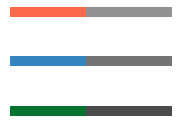

In [2]:
grayscale = False
n_colors = 3
min_intensity = 0.85
max_intensity = 0.5

color_values = np.linspace(min_intensity, max_intensity, n_colors)
color_palettes = ['Greens', 'Blues', 'Reds']
color_build = [mpl.cm.get_cmap(color_palettes[i])(color_values[i]) for i in range(len(color_values))] 
check_colors(color_build, 10)

### INPUTS

In [3]:
# Building results file
building_id = ['ID1012_good', 'ID1012', 'ID1012_bad']
n_stories = 8

# building_id = ['ID1021_good', 'ID1021', 'ID1012_bad']
# n_stories = 20

im = 'sa_avg'

# Damage indicator names
di_types = ["$SDR_{peak}$", "$RSDR_{peak}$", "$FDI_{peak}$", "$DI_{bottom}^{sum}$", "$FDI_{max}^{bottom}$"]

# Minimum value of each damage indicator to consider
di_min = [1e-4, 1e-6, 1e-7, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]

# Transformation for fit and display
di_transformation = "log"

n_scales = 7
n_mainshocks = 44


#### Retrieve damage indicator data per buildng

In [4]:
damage_instances_data = dict()
for b_i in building_id:
    damage_instances_data[b_i] = pd.read_hdf('../1_Data_postprocessing/Damage_Instances_' 
                                             + b_i[0:6] + '_mat_props.h5', key=b_i)

##### Assemble Damage Indicator Matrix per building [check manually those related to fractions of damaged components]

In [5]:
damage_instances_matrix = dict()

for b_i in building_id:
    # Retrieve data of current building
    current_building = damage_instances_data[b_i]
    
    # Matrix of Damage Indicators per damage instance        
    di_matrix = current_building[di_types[0]]
    di_matrix = np.vstack((di_matrix, current_building[di_types[1]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[2]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[3]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[4]]))
    
    damage_instances_matrix[b_i] = copy.deepcopy(np.transpose(di_matrix))
del(di_matrix)

### Pushover curves

#### Import pushover

In [6]:
push_curves = dict()

for b_i in building_id:
    pushover = pd.read_excel('pushover_data/' + b_i + '.xls')
    push_curves[b_i] = copy.deepcopy(pushover)

#### Plot pushover curves

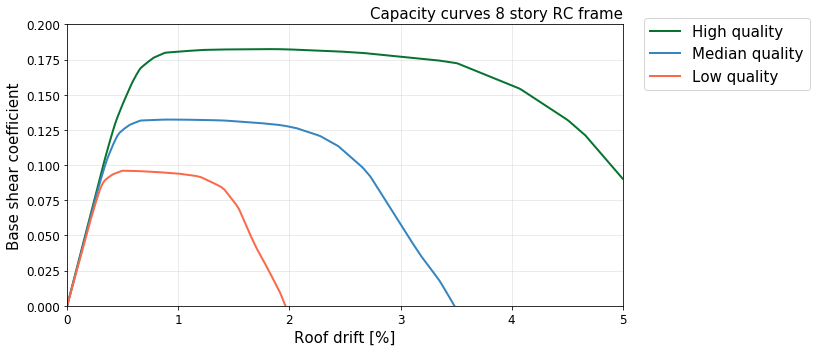

In [7]:
x_push_limits = [0, 5]
y_push_limits = [0, 0.2]
linewidth = 2
labels = ['High quality','Median quality','Low quality']

fig = plt.figure(figsize=(12, 5))

for i, b_i in enumerate(building_id):
    _ = plt.plot(push_curves[b_i].RoofDrift*100, push_curves[b_i].FxRatio, color=color_build[i], 
                 linewidth=linewidth, label=labels[i])

# Formatting
_ = plt.xlim(x_push_limits)
_ = plt.ylim(y_push_limits)
_ = plt.legend(bbox_to_anchor=(0.5, 1.05, 0.85, 0), frameon=True)
_ = plt.grid(which='both', alpha = 0.3)
_ = plt.title('Capacity curves ' + str(n_stories )+ ' story RC frame', loc='right')
_ = plt.ylabel('Base shear coefficient')
_ = plt.xlabel('Roof drift [%]')

plt.tight_layout()
plt.savefig('pushover_' + str(n_stories) + 'story.pdf')

# _ = plt.savefig(filename+'.png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

# Comparison of Damage Indicators

#### Reduction in median collapse capacity

In [8]:
k_min = 0.2

k = dict()

for b_i in building_id:
    # Retrieve data of current building
    k[b_i] = damage_instances_data[b_i]['$\kappa$'].values    
    damage_instances_matrix[b_i] = damage_instances_matrix[b_i][k[b_i] > k_min]
    damage_instances_data[b_i] = damage_instances_data[b_i][k[b_i] > k_min]
    k[b_i] = k[b_i][k[b_i] > k_min]

y_label = '$\kappa$'


#### Fit three-linear curve

In [9]:
parameters = dict()
N_seeds = 20

for b_i in building_id:
    parameters_bi = pd.DataFrame()
    
    for j, di in enumerate(di_types):        
        temp = fitPieceWiseFunc3LinLS(di, damage_instances_matrix[b_i][:, j], k[b_i], di_min[j], di_transformation, N_seeds)
    
        parameters_bi = parameters_bi.append(temp)
        print(b_i + ' ' + di)
        
    parameters[b_i] = copy.deepcopy(parameters_bi)
    parameters[b_i]
    
del(parameters_bi)

ID1012_good $SDR_{peak}$


..\damage_indicator_module\damage_indicators.py:619: RuntimeWarning: invalid value encountered in double_scalars
  b1_0 = np.sum(x1.dot(y1)) / np.sum(x1.dot(x1))
..\damage_indicator_module\damage_indicators.py:535: RuntimeWarning: invalid value encountered in greater
  y_seg1 = y[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicators.py:535: RuntimeWarning: invalid value encountered in less_equal
  y_seg1 = y[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicators.py:536: RuntimeWarning: invalid value encountered in greater
  y_seg2 = y[x > param[2]]
..\damage_indicator_module\damage_indicators.py:538: RuntimeWarning: invalid value encountered in greater
  y_pred_seg1 = y_pred[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicators.py:538: RuntimeWarning: invalid value encountered in less_equal
  y_pred_seg1 = y_pred[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_mod

ID1012_good $RSDR_{peak}$
ID1012_good $FDI_{peak}$
ID1012_good $DI_{bottom}^{sum}$
ID1012_good $FDI_{max}^{bottom}$


,Minimum limit,Threshold limit,Slope 1,Slope 2,k_max,std_residuals,Residuals,x_min,di for plot,k for plot
$SDR_{peak}$,-3.954419,-2.895605,-0.162209,-0.425719,1.012503,0.085828,"[0.019241104820355126, 0.09014737707360632, 0....",1.000000e-04,"[0.0058378399999999995, 0.019169804931522177, ...","[1.0125028875290685, 1.0125028875290685, 0.840..."
$RSDR_{peak}$,-5.955867,-3.494041,-0.055361,-0.292707,0.991265,0.091218,"[0.04047915144331726, 0.05684128144470413, 0.1...",1.000000e-06,"[0.00012139000000000011, 0.002590597090192587,...","[0.9912648409061063, 0.9912648409061063, 0.854..."
$FDI_{peak}$,-4.833012,-1.855799,-0.040287,-0.274229,1.010725,0.083301,"[0.021018854145896215, 0.07746120751033125, 0....",1.000000e-07,"[9.999999999999994e-08, 0.007962502134213146, ...","[1.0107251382035274, 1.0107251382035274, 0.890..."
$DI_{bottom}^{sum}$,-5.103875,-1.369297,-0.029782,-0.294727,1.012925,0.080436,"[0.018819031078936233, 0.07064592496918132, 0....",1.000000e-06,"[1.0000000000000004e-06, 0.006073168852404755,...","[1.0129249612704874, 1.0129249612704874, 0.901..."
$FDI_{max}^{bottom}$,-6.034617,-1.995414,-0.026342,-0.271423,1.015916,0.081845,"[0.01582826560456585, 0.07077832330679379, 0.0...",1.000000e-06,"[1.0000000000000004e-06, 0.0023944143220327035...","[1.0159157267448577, 1.0159157267448577, 0.909..."


ID1012 $SDR_{peak}$
ID1012 $RSDR_{peak}$
ID1012 $FDI_{peak}$
ID1012 $DI_{bottom}^{sum}$
ID1012 $FDI_{max}^{bottom}$


,Minimum limit,Threshold limit,Slope 1,Slope 2,k_max,std_residuals,Residuals,x_min,di for plot,k for plot
$SDR_{peak}$,-4.616544,-3.690995,-0.095966,-0.338277,1.015011,0.084902,"[0.04055617178483906, 0.07788916736092122, 0.1...",1.000000e-04,"[0.003451720000000001, 0.0098869029475135, 0.0...","[1.0150108371363906, 1.0150108371363906, 0.926..."
$RSDR_{peak}$,-6.770235,-4.049706,-0.054178,-0.280049,1.005146,0.086225,"[0.05042133252987191, 0.06961363217967576, 0.1...",1.000000e-06,"[1.4141999999999996e-05, 0.0011474251200783493...","[1.0051456763913578, 1.0051456763913578, 0.857..."
$FDI_{peak}$,-4.916109,-1.762931,-0.034275,-0.288725,1.013508,0.079423,"[0.0420585776092155, 0.08461532951703099, 0.07...",1.000000e-07,"[9.999999999999994e-08, 0.007327588367997038, ...","[1.0135084313120142, 1.0135084313120142, 0.905..."
$DI_{bottom}^{sum}$,-5.001219,-1.175313,-0.029084,-0.316223,1.016098,0.075993,"[0.03946879561865613, 0.06513827674380912, 0.0...",1.000000e-06,"[1.0000000000000004e-06, 0.006729740064784832,...","[1.0160982133025735, 1.0160982133025735, 0.904..."
$FDI_{max}^{bottom}$,-5.219145,-1.765375,-0.032602,-0.296537,1.015948,0.077659,"[0.039618746343692335, 0.06025294161551009, 0....",1.000000e-06,"[1.0000000000000004e-06, 0.005411954770734393,...","[1.0159482625775373, 1.0159482625775373, 0.903..."


ID1012_bad $SDR_{peak}$
ID1012_bad $RSDR_{peak}$
ID1012_bad $FDI_{peak}$
ID1012_bad $DI_{bottom}^{sum}$
ID1012_bad $FDI_{max}^{bottom}$


,Minimum limit,Threshold limit,Slope 1,Slope 2,k_max,std_residuals,Residuals,x_min,di for plot,k for plot
$SDR_{peak}$,-5.306917,-4.082956,-0.069488,-0.419846,1.012459,0.084048,"[0.029643632148845356, 0.09640333927564193, 0....",1.000000e-04,"[0.002125849999999999, 0.004957184280707172, 0...","[1.0124587570599777, 1.0124587570599777, 0.927..."
$RSDR_{peak}$,-7.279593,-4.411561,-0.055116,-0.336863,0.993658,0.093337,"[0.030016811761543027, 0.10876020432202749, 0....",1.000000e-06,"[3.3970000000000015e-05, 0.0006894661204786623...","[0.9936578051464794, 0.9936578051464794, 0.835..."
$FDI_{peak}$,-3.944250,-1.473452,-0.044186,-0.434186,1.000943,0.074928,"[0.022731929020547215, 0.1152244917456774, 0.1...",1.000000e-07,"[9.999999999999994e-08, 0.01936572823873611, 0...","[1.0009426878874752, 1.0009426878874752, 0.891..."
$DI_{bottom}^{sum}$,-2.232598,-0.716371,-0.092885,-0.524347,0.986378,0.073539,"[0.03729681735706869, 0.04065167576255302, 0.0...",1.000000e-06,"[1.0000000000000004e-06, 0.10724940321007921, ...","[0.9863777995509537, 0.9863777995509537, 0.845..."
$FDI_{max}^{bottom}$,-3.629810,-1.400365,-0.055678,-0.476864,0.998464,0.072606,"[0.025210155001457957, 0.054649065686624754, 0...",1.000000e-06,"[1.0000000000000004e-06, 0.026521228191231004,...","[0.9984644619065645, 0.9984644619065645, 0.874..."


In [10]:
for b_i in building_id:
    parameters_bi = parameters[b_i]
    parameters_bi.to_hdf('kappa_function_ID1012_mat_props.h5', key=b_i)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Residuals', 'di for plot', 'k for plot']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


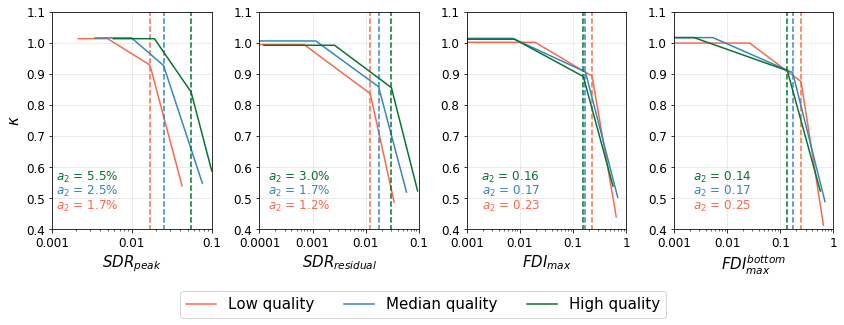

In [11]:
import matplotlib.transforms as transforms

# Concatenate results for all buildings
################### Regression lines to compare ##########################
di_to_plot = ["$SDR_{peak}$", "$RSDR_{peak}$", "$FDI_{peak}$", "$FDI_{max}^{bottom}$"]

x_limits = [[0.001, 0.1], [1e-4, 0.1], [1e-3, 1], [1e-3, 1]]

building_id = [building_id[2], building_id[1], building_id[0]]
labels = [labels[2], labels[1], labels[0]]
color_build = [color_build[2], color_build[1], color_build[0]]
##########################################################################

fig = plt.figure(figsize=(14, 4))

for j, di in enumerate(di_to_plot):
    # Locate the subplot
    ax = plt.subplot2grid((1, 4), (0, j), rowspan=1, colspan=1)
    
    # Plot each lines
    for i, b_i in enumerate(building_id):
        a_plot = parameters[b_i].loc[[di]]['di for plot'][0]
        k_plot = parameters[b_i].loc[[di]]['k for plot'][0]
        _ = plt.plot(a_plot, k_plot, Color=color_build[i], label=labels[i])
        _ = plt.plot([a_plot[2], a_plot[2]], [0, 1.1], linestyle='--', Color=color_build[i], label='_nolegend_')
        
        # Title
        if di == '$SDR_{peak}$' or di == '$RSDR_{peak}$':
            title_text = "$a_2$ = " + str(round(a_plot[2]*100,1)) + '%'
        else:
            title_text = "$a_2$ = " + str(round(a_plot[2],2))
            
        _ = plt.figtext(0.16 + j*0.21, 0.18+0.05*i, title_text , ha="center", 
                        va="bottom",color=color_build[i], fontsize=12)
        
    # Formatting
    if di_to_plot[j] == "$RSDR_{peak}$":
        _ = plt.xlabel("$SDR_{residual}$")
    elif di_to_plot[j] == "$FDI_{peak}$":
        _ = plt.xlabel("$FDI_{max}$")
        
    else:
        _ = plt.xlabel(di_to_plot[j])
    if j == 0:
        _ = plt.ylabel(y_label)

    if j == 3:
        _ = plt.legend(bbox_to_anchor=(0, -0.25), ncol=3)
        
    _ = plt.xlim(x_limits[j])
    _ = plt.ylim([0.4, 1.1])
    _ = plt.xscale('log')
    _ = plt.gca()
    _ = ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
    _ = plt.grid(which='major', alpha=0.3)
    plt.subplots_adjust(wspace=0.3)

plt.tight_layout()

bounds_print = transforms.Bbox([[0, -1], [13, 4]])
plt.savefig('Regression_lines_materials.pdf', bbox_inches = bounds_print)